# Extraction de profils à partir de données

In [14]:
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import matplotlib
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage


#### 1. Appliquez la procédure KMeans sur ce jeu de données pour obtenir 3 clusters • Donner une visualisation graphique des villes projetées dans le plan principal. Les villes de chaque cluster devraient avoir une couleur différente des villes des autres clusters (voir code ci-dessous). X_pca étant la matrice des données transformées par l’ACP, labels étant le vecteur contenant le nom des instances (ici les villes), clustering étant le clustering obtenu.


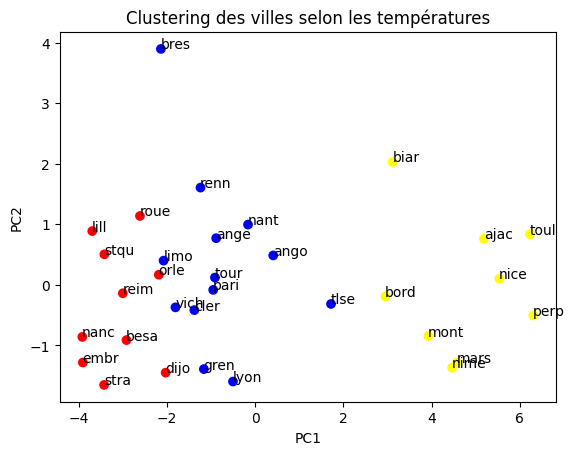

In [2]:
# Chargement des données CSV (remplacez 'data.csv' par le chemin de votre fichier)
df = pd.read_csv('./villes.csv', sep=';')

# Supposons que les colonnes 1 à 12 contiennent les températures mensuelles et la colonne 0 contient les noms des villes
labels = df.iloc[:, 0].values  # Extraction des noms des villes
X = df.iloc[:, 1:].values  # Extraction des données numériques

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Réduction de dimension avec l'ACP pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Application de KMeans avec 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clustering = kmeans.fit_predict(X_scaled)

# Visualisation
colors = ['red', 'yellow', 'blue']
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustering, cmap=matplotlib.colors.ListedColormap(colors))

# Ajout des labels des villes
for label, x, y in zip(labels, X_pca[:, 0], X_pca[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering des villes selon les températures')
plt.show()

#### 2. Appliquez la procédure AgglomerativeClustering sur ce jeu de données pour obtenir trois clusters avec différentes méthodes d’agrégation (il faut essayer ward, average et single). • Donner à chaque fois une visualisation graphique des villes projetées dans le plan principal. Les villes de chaque cluster devraient avoir une couleur différente des villes des autres clusters. 

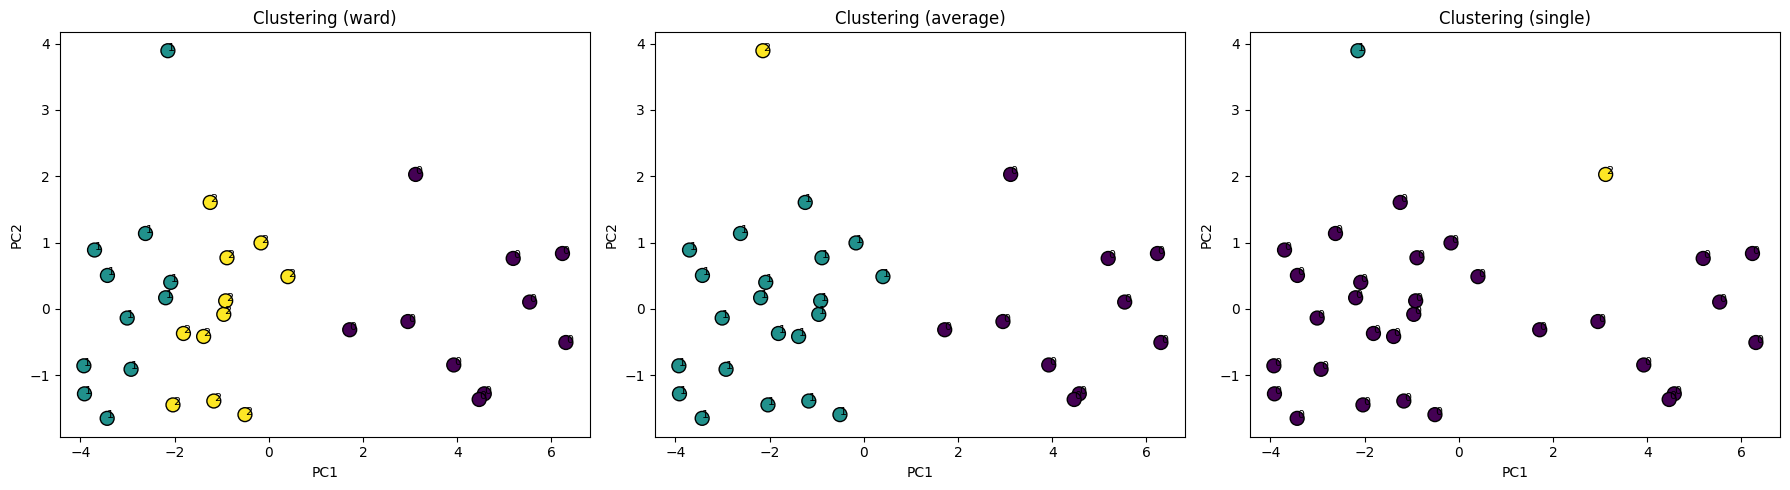

In [3]:
methods = ['ward', 'average', 'single']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, method in enumerate(methods):
    # Appliquer AgglomerativeClustering avec 3 clusters
    cluster = AgglomerativeClustering(n_clusters=3, linkage=method)
    labels = cluster.fit_predict(X_scaled)

    # Visualisation
    axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', edgecolors='k', s=100)
    axes[i].set_title(f"Clustering ({method})")
    axes[i].set_xlabel("PC1")
    axes[i].set_ylabel("PC2")

    # Afficher les noms des villes
    for j, txt in enumerate(labels):
        axes[i].annotate(txt, (X_pca[j, 0], X_pca[j, 1]), fontsize=8)

plt.tight_layout()
plt.show()


#### 3. Utiliser cet indice dans une boucle de 5 itérations au maximum. Les 5 itérations correspondent aux 5 partitions possibles i.e. en 2, 3, 4, 5 et 6 classes issues de KMeans. Déduire la meilleure partition qui correspond à un indice maximal pour l’indice Silhouette.

In [4]:
# Définition des plages de clusters
cluster_range = range(2, 7)  # de 2 à 6 clusters

# Listes pour stocker les scores
silhouette_scores_kmeans = []
silhouette_scores_agglomerative = []

# Boucle sur les valeurs de clusters (max 5 itérations)
for k in cluster_range:
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_kmeans = kmeans.fit_predict(X_scaled)
    score_kmeans = silhouette_score(X_scaled, labels_kmeans)
    silhouette_scores_kmeans.append(score_kmeans)

    # AgglomerativeClustering (Ward)
    agglom = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels_agglom = agglom.fit_predict(X_scaled)
    score_agglom = silhouette_score(X_scaled, labels_agglom)
    silhouette_scores_agglomerative.append(score_agglom)

# Trouver le nombre de clusters optimal (celui avec le max Silhouette Score)
best_k_kmeans = cluster_range[np.argmax(silhouette_scores_kmeans)]
best_k_agglom = cluster_range[np.argmax(silhouette_scores_agglomerative)]

# Affichage du meilleur nombre de clusters
print(f"Meilleur nombre de clusters pour KMeans: {best_k_kmeans} (Silhouette Score: {max(silhouette_scores_kmeans):.3f})")
print(f"Meilleur nombre de clusters pour Agglomerative: {best_k_agglom} (Silhouette Score: {max(silhouette_scores_agglomerative):.3f})")


Meilleur nombre de clusters pour KMeans: 2 (Silhouette Score: 0.626)
Meilleur nombre de clusters pour Agglomerative: 2 (Silhouette Score: 0.626)


#### 4. Utiliser cet indice dans une boucle de 5 itérations au maximum. Les 5 itérations correspondent aux 5 partitions possibles i.e. en 2, 3, 4, 5 et 6 classes issues de AgglomerativeClustering (avec à chaque le critère d’agrégation ward, average et single). Déduire la meilleure partition qui correspond à un indice maximal pour l’indice Silhouette.

In [5]:
# Définition des plages de clusters
cluster_range = range(2, 4)  # de 2 à 6 clusters
linkage_methods = ["ward", "average", "single"]  # Méthodes d’agrégation

# Variables pour stocker le meilleur score et la meilleure configuration
best_k = None
best_method = None
best_score = -1

# Boucle sur les méthodes d’agrégation
for method in linkage_methods:
    for k in cluster_range:
        try:
            # AgglomerativeClustering avec la méthode actuelle
            agglom = AgglomerativeClustering(n_clusters=k, linkage=method)
            labels = agglom.fit_predict(X_scaled)

            # Calcul du Silhouette Score
            score = silhouette_score(X_scaled, labels)

            # Mise à jour si meilleur score trouvé
            if score > best_score:
                best_k = k
                best_method = method
                best_score = score
        except ValueError:
            # Certaines méthodes comme "single" peuvent échouer si les points sont trop proches
            continue

# Affichage des résultats
print(f"🔹 Meilleur nombre de clusters: {best_k} avec la méthode '{best_method}' (Silhouette Score: {best_score:.3f})")


🔹 Meilleur nombre de clusters: 2 avec la méthode 'ward' (Silhouette Score: 0.626)


 #### 5. En considérant 3 clusters, quelle méthode donnera la meilleure partition ?

In [6]:
# Définition des méthodes d’agrégation
linkage_methods = ["ward", "average", "single"]

# Variables pour stocker le meilleur score et la meilleure méthode
best_method = None
best_score = -1

# Test des trois méthodes avec k=3
for method in linkage_methods:
    try:
        # AgglomerativeClustering avec 3 clusters et la méthode actuelle
        agglom = AgglomerativeClustering(n_clusters=3, linkage=method)
        labels = agglom.fit_predict(X_scaled)

        # Calcul du Silhouette Score
        score = silhouette_score(X_scaled, labels)

        print(f" Méthode '{method}' : Silhouette Score = {score:.3f}")

        # Mise à jour si meilleur score trouvé
        if score > best_score:
            best_method = method
            best_score = score
    except ValueError:
        print(f" La méthode '{method}' a rencontré une erreur.")

# Affichage de la meilleure méthode
print(f"\n Meilleure méthode pour 3 clusters : '{best_method}' avec un Silhouette Score de {best_score:.3f}")


 Méthode 'ward' : Silhouette Score = 0.368
 Méthode 'average' : Silhouette Score = 0.496
 Méthode 'single' : Silhouette Score = -0.034

 Meilleure méthode pour 3 clusters : 'average' avec un Silhouette Score de 0.496


### Avantages et inconvénients des méthodes de classification hiérarchiques (AgglomerativeClustering) et celles de partitionnement (KMeans)

#### AgglomerativeClustering (Classification hiérarchique)

**Avantages :**
1. **Interprétabilité** : Les dendrogrammes permettent de visualiser les relations entre les points de données et les étapes de fusion.
2. **Pas besoin de spécifier le nombre de clusters** : Contrairement à KMeans, il n'est pas nécessaire de définir le nombre de clusters à l'avance.
3. **Flexibilité** : Peut utiliser différentes mesures de distance et critères de liaison (single, complete, average, etc.).
4. **Robustesse aux formes de clusters** : Peut identifier des clusters de formes variées (non sphériques).

**Inconvénients :**
1. **Complexité computationnelle** : Généralement plus coûteux en termes de temps de calcul et de mémoire, surtout pour de grands ensembles de données.
2. **Sensibilité au bruit et aux outliers** : Les points aberrants peuvent influencer fortement la structure hiérarchique.
3. **Difficulté à ajuster** : Une fois qu'une fusion ou une division est faite, elle ne peut pas être annulée.

#### KMeans (Partitionnement)

**Avantages :**
1. **Simplicité et rapidité** : Algorithme simple et rapide à exécuter, surtout pour de grands ensembles de données.
2. **Scalabilité** : Peut facilement être appliqué à de grands ensembles de données.
3. **Facilité d'interprétation** : Les clusters sont définis par leurs centres, ce qui est facile à comprendre et à interpréter.
4. **Efficacité** : Converge généralement rapidement vers une solution.

**Inconvénients :**
1. **Nombre de clusters à définir** : Nécessite de spécifier le nombre de clusters à l'avance, ce qui peut être difficile sans connaissance préalable.
2. **Sensibilité aux valeurs initiales** : Les résultats peuvent varier en fonction des centres initiaux choisis.
3. **Forme des clusters** : Suppose que les clusters sont sphériques et de taille similaire, ce qui peut ne pas être le cas dans la réalité.
4. **Sensibilité aux outliers** : Les points aberrants peuvent fortement influencer les centres des clusters.

En résumé, le choix entre AgglomerativeClustering et KMeans dépend des caractéristiques spécifiques de vos données et des objectifs de votre analyse.

#### 7 . Proposer dans une fonction une éventuelle approche permettant de combiner les points forts des méthodes hiérarchiques et des méthodes de partitionnement : on appelle une telle approche mixte ou hybride. Proposer une visualisation du nuage des villes et comparer les résultats obtenus avec ceux des questions précédentes.

Clustering pour villes.csv


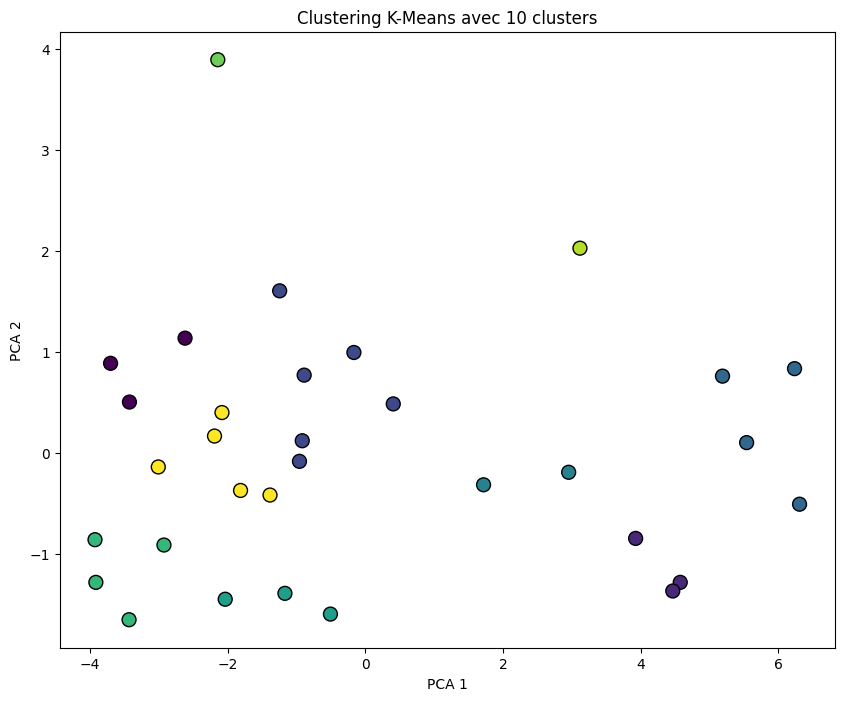

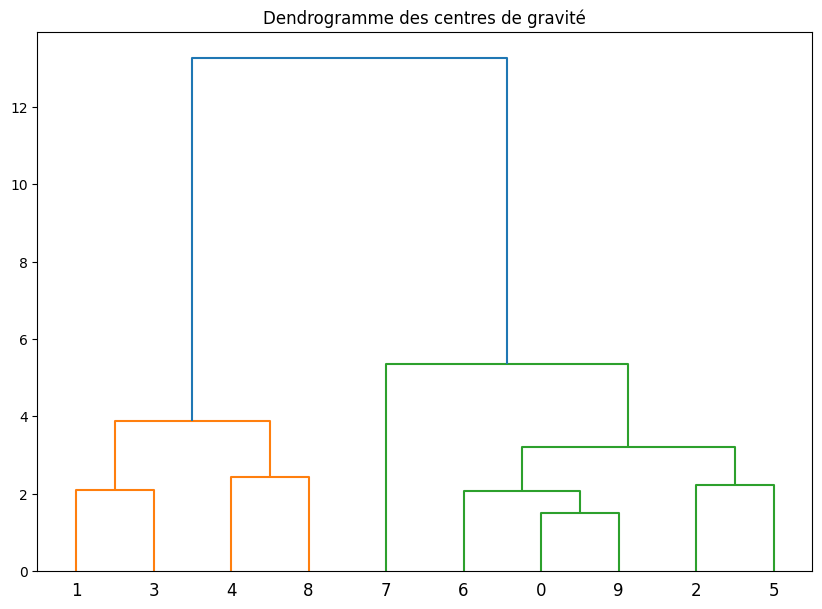

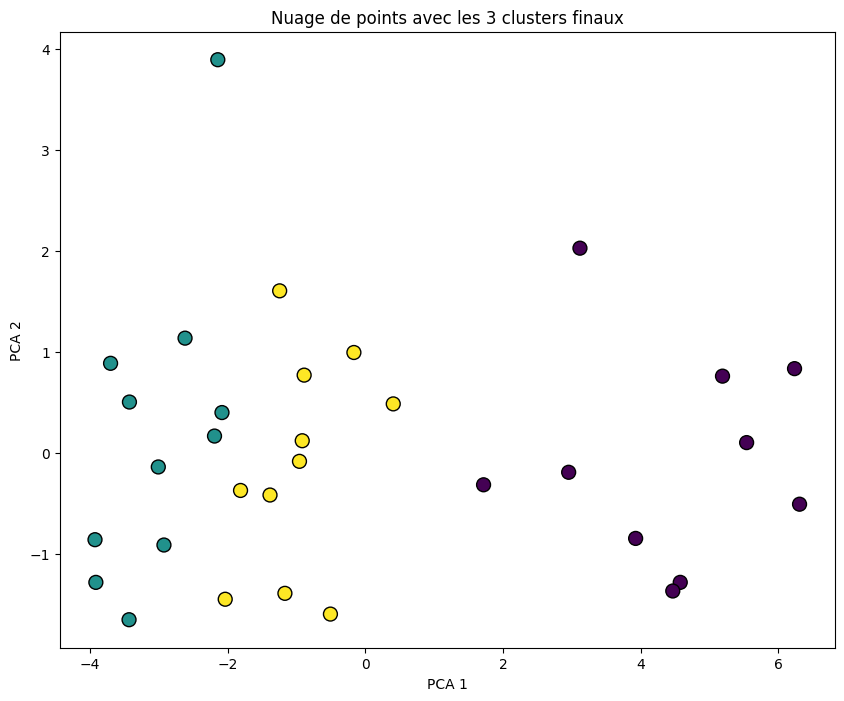

In [56]:
def hybrid_clustering(file_path, n_clusters_kmeans=10, n_clusters_final=3):
    """
    Applique une approche hybride de clustering en combinant KMeans et CAH.
    
    Parameters:
    - file_path: Chemin vers le fichier CSV contenant les données à analyser.
    - n_clusters_kmeans: Nombre de clusters pour l'étape KMeans.
    - n_clusters_final: Nombre de clusters finaux après CAH.
    
    Returns:
    - final_labels: Labels des clusters finaux pour chaque point de données.
    """


    # Chargement des données CSV (remplacez 'data.csv' par le chemin de votre fichier)
    data = pd.read_csv(file_path, sep=';')

    # Supposons que les colonnes 1 à 12 contiennent les températures mensuelles et la colonne 0 contient les noms des villes
    labels = data.iloc[:, 0].values  # Extraction des noms des villes
    X = data.iloc[:, 1:].values  # Extraction des données numériques

    # Standardisation des données
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Réduction de dimension pour la visualisation
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Application de KMeans avec n_clusters_kmeans clusters
    kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42, n_init=10)
    clustering = kmeans.fit_predict(X_scaled)

    # Visualisation des clusters K-Means
    plt.figure(figsize=(10, 8))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustering, cmap='viridis', edgecolors='k', s=100)
    plt.title(f"Clustering K-Means avec {n_clusters_kmeans} clusters")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()

    # Utiliser les centres de gravité pour une classification ascendante hiérarchique
    centers = kmeans.cluster_centers_
    linked = linkage(centers, method='ward')

    # Tracer le dendrogramme
    plt.figure(figsize=(10, 7))
    dendrogram(linked)
    plt.title('Dendrogramme des centres de gravité')
    plt.show()

    # Découper l'arbre hiérarchique en n_clusters_final classes
    hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters_final, metric='euclidean', linkage='ward')
    final_labels = hierarchical_clustering.fit_predict(X_scaled)

    # Visualiser les résultats finaux avec annotations
    plt.figure(figsize=(10, 8))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=final_labels, cmap='viridis', edgecolors='k', s=100)
    plt.title(f'Nuage de points avec les {n_clusters_final} clusters finaux')
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()

    return final_labels


print("Clustering pour villes.csv")
final_labels_villes = hybrid_clustering('villes.csv')


#### 8. Appliquer la fonction précédente sur les jeux de données "wdbc.csv" et "spamb.csv". 

Clustering pour wdbc.csv


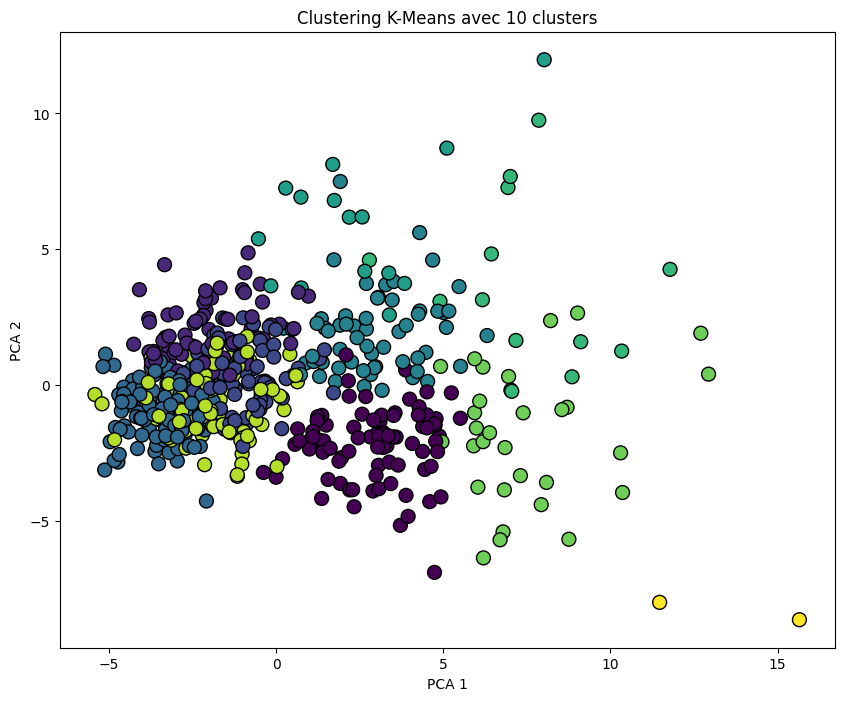

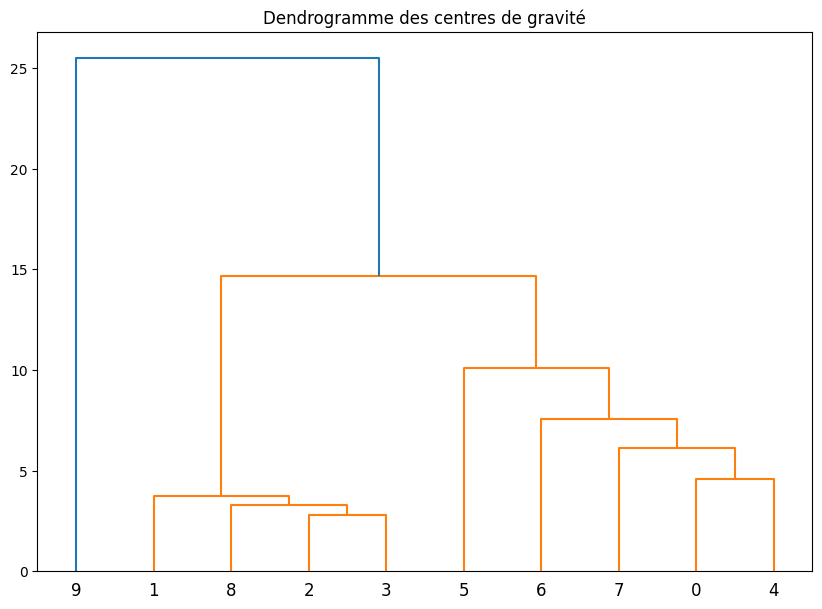

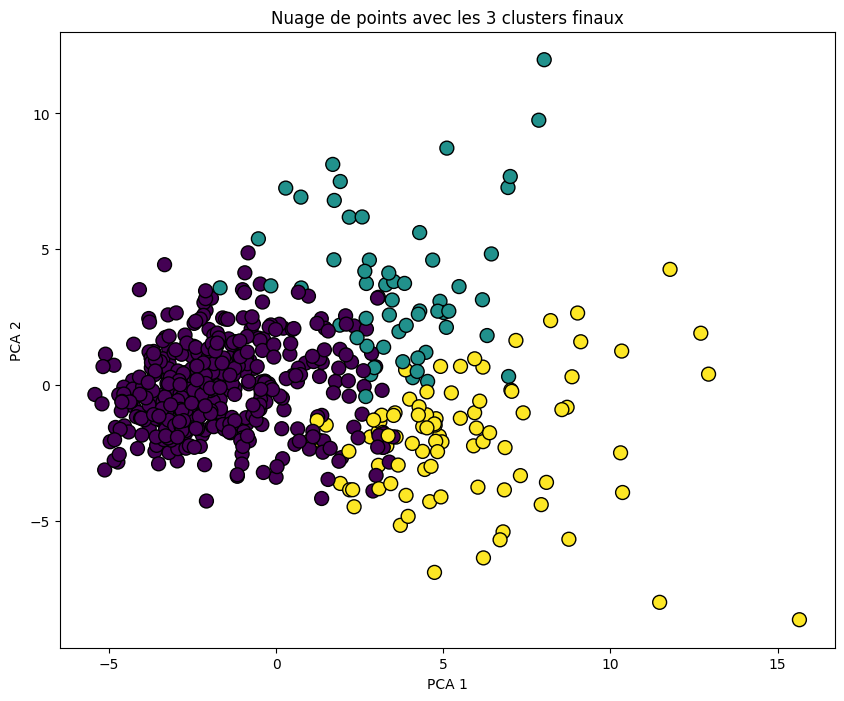

Clustering pour spamb.csv


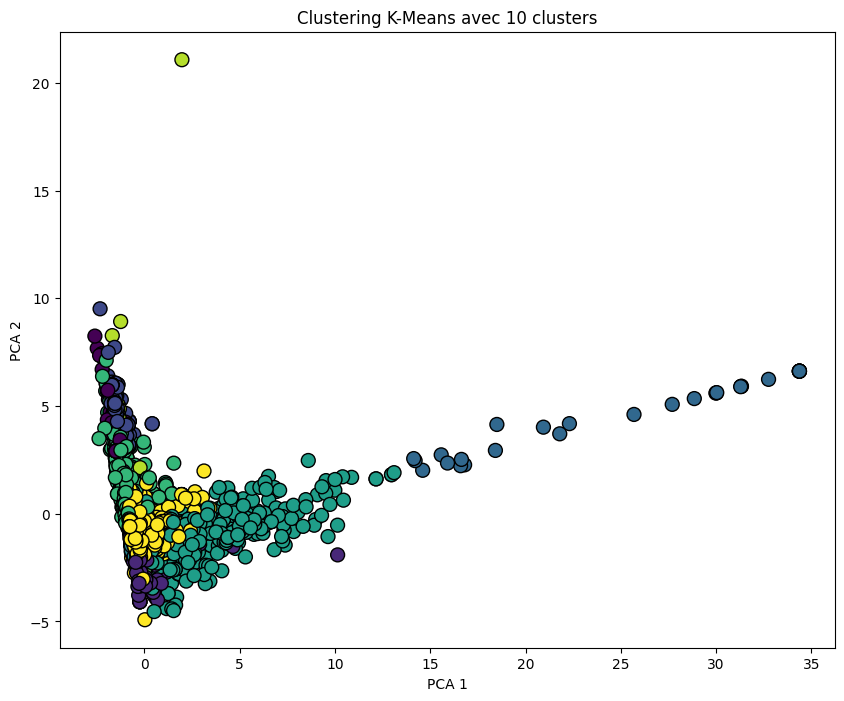

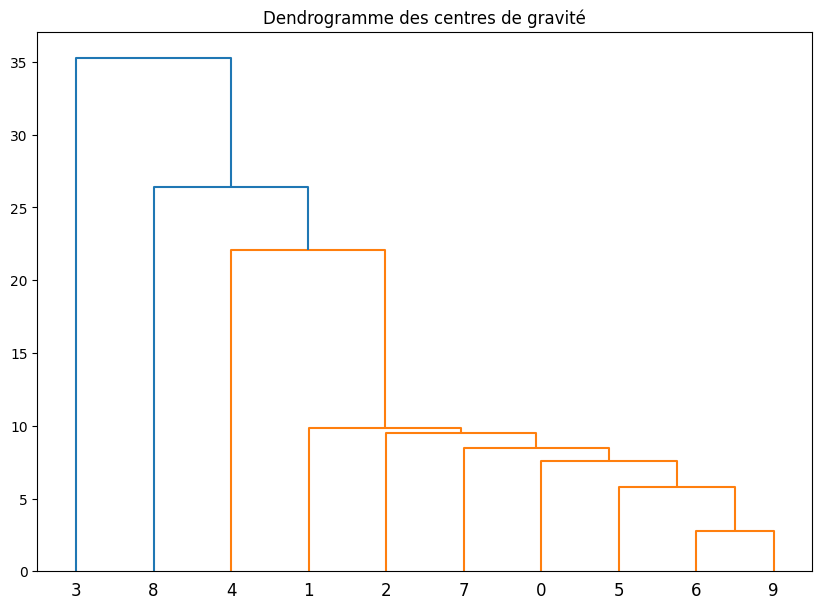

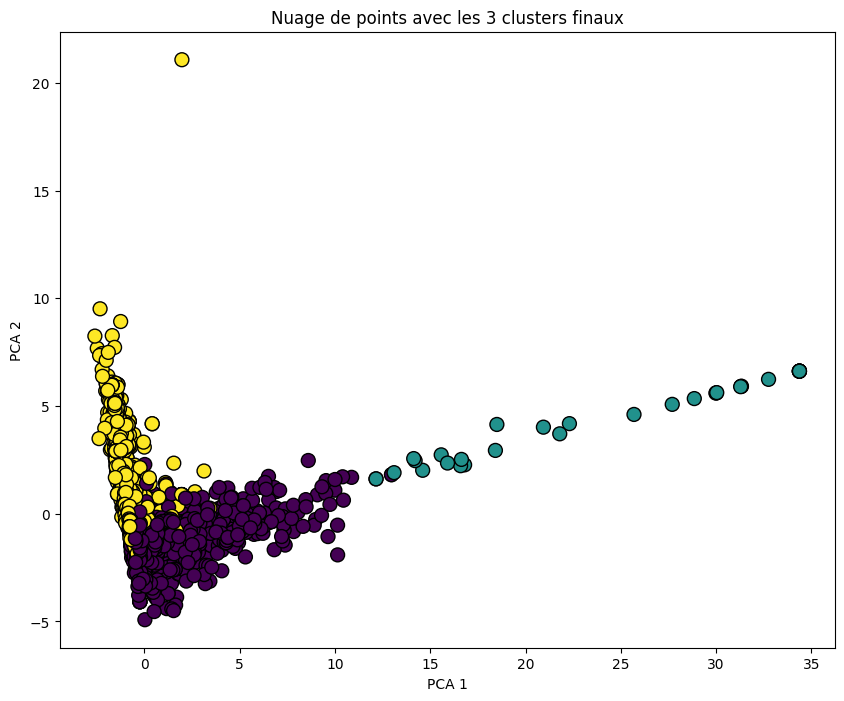

In [57]:
print("Clustering pour wdbc.csv")
final_labels_wdbc = hybrid_clustering('wdbc.csv')

print("Clustering pour spamb.csv")
final_labels_spamb = hybrid_clustering('spamb.csv')